# Get the signal to noise of a Cluster mass estimation

Following Eq. 26 of Zubeldia and Challinor 2019

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

import lensit as li
from lensit.misc.misc_utils import pp_to_kk
from lensit.clusterlens import lensingmap, profile

import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from plancklens import n0s
from plancklens.helpers import cachers


from lensitbiases import wrappers_lensit as wli, n0_fft, len_fft


***could not import bicubic fortran module
***I wont be able to lens maps or invert a deflection field


In [3]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [4]:
import pickle as pk 

class cacher_pk(cachers.cacher):
    def __init__(self, lib_dir, verbose=False):
        if not os.path.exists(lib_dir):
            os.makedirs(lib_dir)
        self.lib_dir = lib_dir
        self.verbose = verbose

    def _path(self, fn):
        return os.path.join(self.lib_dir, fn + '.pk')

    def cache(self, fn, obj):
        assert '.pk' not in fn
        pk.dump(obj, open(os.path.join(self.lib_dir, fn + '.pk'), 'wb'))
        if self.verbose: print("Cached " + fn + '.pk')

    def load(self, fn):
        assert '.pk' not in fn
        p = self._path(fn)
        assert os.path.exists(p)
        if self.verbose:
            print("Loading " + fn + '.pk')
        return pk.load(open(p, 'rb'))

    def is_cached(self, fn):
        return os.path.exists(self._path(fn))


In [5]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)


In [6]:
# We define here the parameters for the profile of the cluster
M200 = 1e14
z = 1
profname = 'nfw'
# profparams={'M200c':M200, 'z':z}

# Set CMB experiment for noise level and beam
# cmb_exp='S4_opti'
# cmb_exp='S4_opti'
# nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)

cmb_exp='S4_opti' # S4_opti config
# cmb_exp='S4_opti_6000' # S4_opti config up to 6000

# cmb_exp='Planck45' # Planck Z and C config up to 2048
# cmb_exp='Planck45_lmax3000' # Planck Z and C config up to 3000

nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)


names = {'S4_opti':'S4, lmax=3000', 'S4_opti_6000':'S4, lmax=6000',
        'Planck45':'Planck, lmax=2048', 'Planck45_lmax3000':'Planck, lmax=3000' }

# nlev_t = 45.
# nlev_p = 45*np.sqrt(2)
# beam_fwhm_amin = 5
# lmin_cmb = 10
# lmax_cmb = 3000


haloprofile = profile.profile(results, profname)

In [7]:
lmax = 6000
ell = np.arange(lmax+1)

In [8]:
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

In [12]:
kappa_ell = haloprofile.analitic_kappa_ft(M200, z, ell)

/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:151: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:152: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


[]

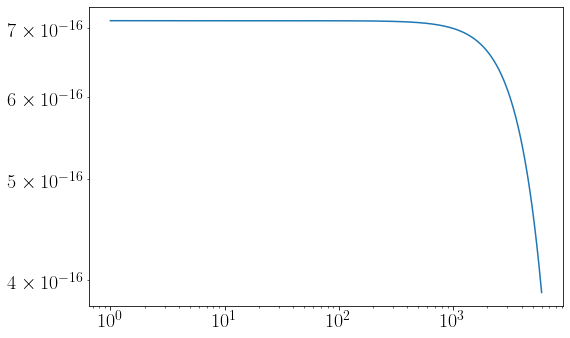

In [21]:
plt.plot(ell, kappa_ell**2)
# plt.plot(ell, cpp_fid[ell]*pp_to_kk(ell), c='k')
plt.loglog()


In [10]:
from os.path import join as opj
import os

TEMP = opj('temp', 'N0s')

libdir = lambda cmb_exp: opj(TEMP, cmb_exp)
cacher = cacher_pk(libdir(cmb_exp))


In [11]:
fn_n0 = 'N0s'
fn_n0_curl = 'N0s_curl'
if np.any([not cacher.is_cached(fn) for fn in [fn_n0, fn_n0_curl]]):
    N0s, N0s_curl = n0s.get_N0(beam_fwhm_amin, nlev_t, nlev_p, lmax_CMB=lmax_cmb, lmin_CMB=lmin_cmb, lmax_out=lmax)
    cacher.cache(fn_n0, N0s)
    cacher.cache(fn_n0_curl, N0s_curl)
N0s = cacher.load(fn_n0)
N0s_curl = cacher.load(fn_n0_curl)


In [18]:
k = 'p'
itmax = 10

fn_n0 = f'N0s_it{itmax}_{k}'
if not cacher.is_cached(fn_n0):
    N0s_it, _ = n0s.get_N0_iter(k, nlev_t, nlev_p, beam_fwhm_amin, cls_unl_fid,  lmin_cmb=lmin_cmb, lmax_cmb=lmax_cmb, itermax=itmax, lmax_qlm=lmax)
    cacher.cache(fn_n0, N0s_it)
N0s_it = cacher.load(fn_n0)[-1]

Text(0.5, 1.0, 'S4, lmax=3000')

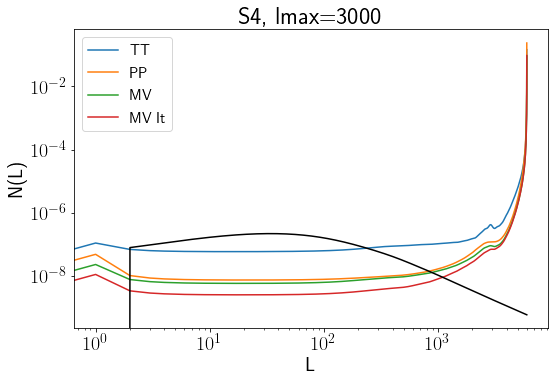

In [19]:


labels = {'tt':'TT', '_p':'PP', '':'MV'}
for k in list(N0s.keys()):
    plt.plot(ell, pp_to_kk(ell)*N0s[k][ell], label=labels[k[1:]])
plt.plot(ell, pp_to_kk(ell)*N0s_it[ell], label='MV It')
plt.plot(ell, pp_to_kk(ell)*cpp_fid[ell], c='k')
plt.loglog()

plt.xlabel('L')
plt.ylabel('N(L)')
plt.legend()

plt.title(names[cmb_exp])

In [24]:
kappa0 = haloprofile.get_kappa0(M200, z)


NL = {}
for k in  ['ptt', 'p_p', 'p']:
    NL[k] = N0s[k] + cpp_fid

NL_it = {}
NL_it['p'] = N0s_it + cpp_fid

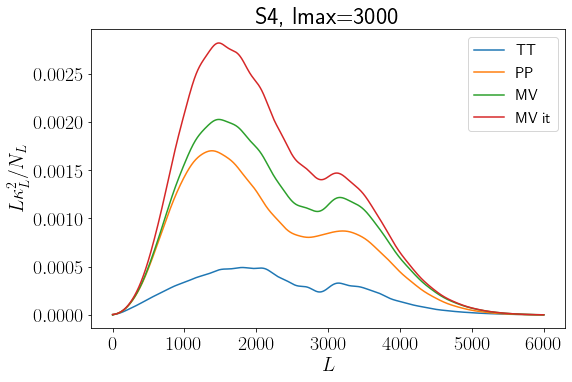

In [33]:
for k in ['ptt', 'p_p', 'p']:
   
    # snr = ell*(kappa_ell[ell]/kappa0)**2/(N0s[k][ell]*pp_to_kk(ell))
    snr = ell*(kappa_ell[ell]/kappa0)**2/(NL[k][ell]*pp_to_kk(ell))
    snr[0] = 0 
    # sigma_kappa0 = np.sqrt(1/2*np.pi * 1/(np.trapz(snr, ell)))
    plt.plot(ell, snr, label=f"{labels[k[1:]]}") #, $\sigma_\kappa=${sigma_kappa0:.2f}")

snr = ell*(kappa_ell[ell]/kappa0)**2/(NL_it['p'][ell]*pp_to_kk(ell))
plt.plot(ell, snr, label="MV it")

plt.xlabel(r'$L$')
plt.ylabel(r'$L \kappa_L^2 / N_L$')
# plt.grid()
plt.title(names[cmb_exp])
plt.legend()

In [32]:
N_clusters = 1000 

for k in ['ptt', 'p_p', 'p']:
    snr = ell*(kappa_ell[ell]/kappa0)**2/(NL[k][ell]*pp_to_kk(ell))
    snr[0] = 0
    sigma_kappa0 = np.sqrt(1/(2*np.pi) * 1/(np.trapz(snr, ell)))
    # print(f"{labels[k[1:]]}, $\sigma_\kappa=${sigma_kappa0:.2f}")
    # print(f"{labels[k[1:]]}, $\sigma_{{M_{{200}}}} ={M200 * sigma_kappa0 / kappa0:.3e}$")
    print(f"{labels[k[1:]]}, $\sigma_{{M_{{200}}}} / M_{200}={sigma_kappa0 / kappa0 / np.sqrt(N_clusters):.3f}$")


snr = ell*(kappa_ell[ell]/kappa0)**2/(NL_it['p'][ell]*pp_to_kk(ell))
snr[0] = 0
sigma_kappa0 = np.sqrt(1/(2*np.pi) * 1/(np.trapz(snr, ell)))
print(f"MV It, $\sigma_{{M_{{200}}}} / M_{200}={sigma_kappa0 / kappa0 / np.sqrt(N_clusters):.3f}$")


TT, $\sigma_{M_{200}} / M_200=0.083$
PP, $\sigma_{M_{200}} / M_200=0.047$
MV, $\sigma_{M_{200}} / M_200=0.042$
MV It, $\sigma_{M_{200}} / M_200=0.037$
